In [3]:
from __future__ import division
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import time
import datetime
from dateutil.parser import parse
from shapely.geometry import LineString, Polygon, Point
from shapely.ops import cascaded_union
from sklearn.neighbors import KDTree
%matplotlib inline

In [2]:
DEP = 'IAH'
ARR = 'BOS'
Year = 2013
print(DEP,'-->',ARR)

('IAH', '-->', 'BOS')


In [4]:
VTrackPath = os.getcwd() + '/TFMS_NEW/New_' + DEP + ARR + str(Year) + '.csv'
VTrack = pd.read_csv(VTrackPath, parse_dates=[6])
LabelData = pd.read_csv(os.getcwd() + '/TFMS_NEW/Label_' + DEP+'_' + ARR+ '_' + str(Year) + '.csv', parse_dates=[6])
CenterTraj = VTrack[VTrack.FID.isin(LabelData[LabelData.MedianID != -2].FID.values)].reset_index(drop = 1)


In [94]:
MIT_All = pd.read_csv(os.getcwd()+'/TMI/MIT_All_Merge.csv', sep = ',',parse_dates=[4,6])
Airways = pd.read_csv(os.getcwd() + '/TMI/Geometry/Airways_CleanRelevant.csv')
Navaids = pd.read_csv(os.getcwd() + '/TMI/Geometry/FixesNavaids_CleanRelevant.csv')
TRACON = pd.read_csv(os.getcwd() + '/TMI/Geometry/TRACON.csv')

In [95]:
# Convert TRACON into single polygon, with name unique
def GetPolygon(x):
    BoundaryCoords = map(float,x.split())
    return Polygon(zip(BoundaryCoords[0::2], BoundaryCoords[1::2]))
TRACON['geometry'] = TRACON.BOUNDARY.apply(lambda x: GetPolygon(x))
TRACON_POLY = TRACON.groupby('TRACON_ID').geometry.apply(lambda x: cascaded_union(x)).reset_index()

In [96]:
Facilities = np.unique(MIT_All[['FRFAC','TOFACSINGLE']].values.reshape(1,-1))
Fixes = MIT_All[(MIT_All.NAS_ELEM_TYPE == 'NAVAID')|(MIT_All.NAS_ELEM_TYPE == 'FIX')].NAS_ELEM_SINGLE.unique()
JetRoutes = MIT_All[(MIT_All.NAS_ELEM_TYPE == 'AIRWAY')].NAS_ELEM_SINGLE.unique()
Centers = MIT_All[(MIT_All.NAS_ELEM_TYPE == 'POLY')].NAS_ELEM_SINGLE.unique()
Others = MIT_All[pd.isnull(MIT_All.NAS_ELEM_TYPE)].NAS_ELEM_SINGLE.unique()

In [97]:
# Convert Jet Route into linestrings, with name unique
Airways_Relevant = Airways[(Airways.NAME.isin(JetRoutes))|
                           (Airways.NAME.isin(Others))].sort_values(by = 
                                                                    ['NAME', 'DIRECTION', 'SEQ']).reset_index(drop = True)

In [98]:
def ToLine(x):
    return LineString(zip(x.LON, x.LAT))

Airways_Relevant_geo = Airways_Relevant.groupby(['NAME','DIRECTION'])[['LON','LAT']].apply(lambda x: ToLine(x)).reset_index()
Airways_Relevant_geo.columns = ['NAME','DIRECTION','geometry']

In [99]:
Navaids_Relevant = Navaids[(Navaids.NAME.isin(Fixes))|(Navaids.NAME.isin(Others))].reset_index(drop = True)[['NAME','LAT','LON']]
TRACON_Relevant = TRACON_POLY[TRACON_POLY.TRACON_ID.isin(Facilities)].reset_index(drop = True)
ARTCC_Relevant = gpd.GeoDataFrame.from_file(os.getcwd()+'/ARTCC/artcc_cont.shp')[['Name','geometry']]
# ZAN (AK) and ZHN (HI) no data avaliable
ARTCC_Relevant['Name'] = ARTCC_Relevant['Name'].apply(lambda x: x[-3:])
TRACON_Relevant.columns = ['Name','geometry']
Navaids_Relevant = Navaids[(Navaids.NAME.isin(Fixes))|(Navaids.NAME.isin(Others))].reset_index(drop = True)[['NAME','LAT','LON']]
Navaids_Relevant['geometry'] = Navaids_Relevant.apply(lambda x: Point(x.LON, x.LAT), axis = 1)
Navaids_Relevant = Navaids_Relevant[['NAME','geometry']]

In [100]:
Facility_Relevant = ARTCC_Relevant.append(TRACON_Relevant).reset_index(drop = True)
NAS_ELEM_Relevant = Navaids_Relevant.append(Airways_Relevant_geo).reset_index(drop = True)

In [102]:
MIT_All.groupby('FRFAC').HEADID.count().sort_values()

FRFAC
CLT        2
PBI        2
SAT        2
D01        3
F11        5
CVG        8
CLE        9
S56       11
ZAN       14
ZHN       14
SDF       19
IND       32
I90       56
NCT      103
A90      106
SCT      235
ZDV      279
ZKC      370
ZLC      374
PHL      556
ZBW     1179
ZFW     1270
ZME     1938
ZJX     2054
ZMA     2176
ZAB     2394
ZMP     2429
ZOA     2487
ZHU     2624
D21     3026
ZID     3719
N90     5338
PCT     7496
ZTL    12329
ZNY    13123
ZLA    15491
ZOB    21192
ZDC    21541
ZAU    27539
Name: HEADID, dtype: int64

## Merge MIT with Geometry Files

In [103]:
MIT_All_geo = MIT_All.merge(Facility_Relevant, \
                   left_on = 'FRFAC', right_on = 'Name', how = 'left').merge(\
                       Facility_Relevant, left_on = 'TOFACSINGLE', right_on = 'Name', how = 'left').merge(\
                            NAS_ELEM_Relevant, left_on = 'NAS_ELEM_SINGLE', right_on = 'NAME', how = 'left')

In [104]:
MIT_All_geo.columns.values[-1] = 'NAS_ELEM_geo'
MIT_All_geo.columns.values[-4] = 'Pro_FAC_geo'
MIT_All_geo.columns.values[-6] = 'Req_FAC_geo'
MIT_All_geo = MIT_All_geo.drop(['Name_x','Name_y','NAME'], axis = 1)
MIT_All_geo.NAS_ELEM_geo.fillna(MIT_All_geo.Req_FAC_geo, inplace = True)
MIT_All_geo = MIT_All_geo[~MIT_All_geo.ALTITUDE.isin(['RAL','RALT','190D150'])].reset_index(drop = 1)

In [106]:
def GetAltSign(x):
    if pd.isnull(x):
        return np.nan
    elif type(x) != str:
        return 0
    else:
        if '+' in x:
            return 1
        else:
            return -1
def GetAltVal(x):
    if pd.isnull(x):
        return np.nan
    elif type(x) != str:
        return x
    else:
        if '+' in x:
            return int(x[:-1])
        else:
            return -int(x[:-1])        
MIT_All_geo['ALTITUDE_SIGN'] = MIT_All_geo.ALTITUDE.apply(lambda x: GetAltSign(x))
MIT_All_geo['ALTITUDE_VALUE']= MIT_All_geo.ALTITUDE.apply(lambda x: GetAltVal(x))

In [107]:
MIT_All_geo.head(1)

,HEADID,RSTN_TYPE_TEXT,FRFAC,TOFACSINGLE,RSTN_START,DURATION_HRS_TOT,RSTN_STOP,RSTNTYPE_TEXT,REASON_TXT,ALTITUDE,SPD,MITVAL,NAS_ELEM_SINGLE,NAS_ELEM_TYPE,Req_FAC_geo,Pro_FAC_geo,DIRECTION,NAS_ELEM_geo,ALTITUDE_SIGN,ALTITUDE_VALUE
0,5060357,MIT,ZLA,ZOA,2013-01-01,4.0,2013-01-01 04:00:00,Arrivals,VOL:Compacted Demand,NaN,NaN,10,AVE,NAVAID,POLYGON Z ((-123.2499999999999 34.500000000000...,"POLYGON Z ((-126.9 40.98333333300008 0, -125.3...",NaN,POINT (-119.9786111 35.6469722),NaN,NaN


In [109]:
pickle.dump(MIT_All_geo,open(os.getcwd() + '/TMI/MIT_WithGeometry_All.p', 'w'))

# Start Mapping!!

In [28]:
class MappingMIT:
    def __init__(self, Dep, Arr, Year, MIT_Enroute):
        # load data
        VTrackPath = os.getcwd() + '/TFMS_NEW/New_' + Dep + Arr + str(Year) + '.csv'
        VTrack = pd.read_csv(VTrackPath, parse_dates=[6])
        self.LabelData = pd.read_csv(os.getcwd() + '/TFMS_NEW/Label_' + DEP+'_' + ARR+ '_' + str(Year) + '.csv', parse_dates=[6])
        self.CenterTraj = VTrack[VTrack.FID.isin(self.LabelData[self.LabelData.MedianID != -2].FID.values)].reset_index(drop = 1)
        self.CenterFlightID = self.CenterTraj.FID.unique()
        self.MIT_Enroute = MIT_Enroute
        # Convert Geometry, Build trees
        self.Traj_Line, self.Traj_Tree = self.ConvertGeometry()
        
    def ProcessMIT(self):
        return
    
    def ConvertGeometry(self):
        # Convert coordinates into linestrings
        # Build a tree
        Traj_Line = {}
        Traj_Tree = {} # 2d dictionary. {tree, DT np array}
        for fid in self.CenterTraj.FID.unique():
            traj_coords = np.array(zip(self.CenterTraj[self.CenterTraj.FID == fid].Lon, self.CenterTraj[self.CenterTraj.FID == fid].Lat))
            Traj_Line[fid] = LineString(traj_coords)
            Traj_Tree[fid] = [KDTree(traj_coords), self.CenterTraj[self.CenterTraj.FID == fid].DT.cumsum().values,\
                             self.CenterTraj[self.CenterTraj.FID == fid].Alt.values*100]
        return Traj_Line, Traj_Tree
    
    def MatchMit(self, departure, Trajectory, Traj_KDtree, MIT):
        # Trajectory should be a LineString
        # TrajID should be the FID of the matching Trajectory (center)
        # MIT should be a np array containing MITID, TOFAC, FRFAC, NAS_ELEM, NAS_ELEM_TYPE, Alt, MITVAL, DURATION, ...        
#         if MIT.NAS_ELEM_TYPE == 'AIRWAY':
        if MIT[13] == 'AIRWAY':
            BUFFER = 0.25 ##
            k = 1
        elif MIT[13] == 'POLY':
            BUFFER = 0  ##
            k = 0
        else:
            BUFFER = 0.5  ##
            k = 0
        try:
            if k == 0:
                CrossPt_NAS = Trajectory.intersection(MIT[17].buffer(BUFFER)).coords[0][:2]
            else:
                if Trajectory.intersection(MIT[17].buffer(BUFFER)).length >= 0.75: ##
                    CrossPt_NAS = Trajectory.intersection(MIT[17].buffer(BUFFER)).coords[0][:2]
                else:
                    return 0
            
            CrossPt_Pro = Trajectory.intersection(MIT[15]).coords[0][:2]
            CrossPt_Req = Trajectory.intersection(MIT[14]).coords[0][:2]
        except:
            return 0
        
        CrossPt_Combine = np.array((CrossPt_Pro, CrossPt_Req, CrossPt_NAS))
        nearestidx = Traj_KDtree[0].query(CrossPt_Combine)[1]
        if nearestidx[0] > nearestidx[1]:
            return 0
        else:
            DeltaSec = Traj_KDtree[1][nearestidx[-1]][0]
            Altitude = Traj_KDtree[2][nearestidx[-1]][0]
            
            if np.isnan(MIT[19]):
                CrossTime = departure + datetime.timedelta(seconds = DeltaSec)
                if CrossTime >= MIT[4] and CrossTime <= MIT[6]:
                    return MIT[0] # MIT_ID
                #    return MIT[[0,11,5]] # MIT_ID, VALUE, DURATION
                else:
                    return 0
            else:
                if MIT[18] == 0:
                    if Altitude >= MIT[19] - 1000 and Altitude <= MIT[19] + 1000:
                        CrossTime = departure + datetime.timedelta(seconds = DeltaSec)
                        if CrossTime >= MIT[4] and CrossTime <= MIT[6]:
                            return MIT[0] # MIT_ID
#                             return MIT[[0,11,5]] # MIT_ID, VALUE, DURATION
                        else:
                            return 0
                    else:
                        return 0
                else:
                    if Altitude * MIT[18] >= MIT[19]:
                        CrossTime = departure + datetime.timedelta(seconds = DeltaSec)
                        if CrossTime >= MIT[4] and CrossTime <= MIT[6]:
                            return MIT[0] # MIT_ID
#                             return MIT[[0,11,5]] # MIT_ID, VALUE, DURATION
                        else:
                            return 0
                    else:
                        return 0
        
    def Main(self):
        Mapping_result = {}
        Airborne = self.CenterTraj.groupby('FID').DT.sum() # seconds
        st = time.time()
        for i in range(self.LabelData.shape[0]):
            if i % 500 == 0:
                print(i, time.time() - st)
    
            departureTime = self.LabelData.loc[i, 'Elap_Time']
            FFID = self.LabelData.loc[i, 'FID']
            Mapping_result[FFID] = {}
#             print '---------->', FFID
            
            for fid in self.CenterFlightID:
                EndTime = departureTime + datetime.timedelta(seconds = Airborne.loc[fid])
                ValidMIT = self.MIT_Enroute[(self.MIT_Enroute.RSTN_START < EndTime) & (self.MIT_Enroute.RSTN_STOP > departureTime)]
                if ValidMIT.shape[0] == 0:
                    Mapping_result[FFID][fid] = np.array([0])
                else:
    #                 for mit in ValidMIT.itertuples():
                    for idx, mit in enumerate(ValidMIT.values):
                        Mapping_result[FFID][fid] = []
                        Mapping_result[FFID][fid].append(self.MatchMit(departureTime, self.Traj_Line[fid], self.Traj_Tree[fid], mit))
                    Mapping_result[FFID][fid] = np.unique(np.array(Mapping_result[FFID][fid]))
        return Mapping_result

In [16]:
import GetMIT_Map

In [113]:
reload(GetMIT_Map)

<module 'GetMIT_Map' from 'GetMIT_Map.py'>

In [3]:
MIT_Enroute_geo = pickle.load(open(os.getcwd() + '/TMI/MIT_WithGeometry_Enroute.p'))

In [114]:
IAH_BOS = GetMIT_Map.MappingMIT('IAH','BOS',2013,MIT_Enroute_geo, Type = 'Nominal')
Mapping_result = IAH_BOS.Main(parameters = {'AIRWAY':[0.25, 1], 'NAS': 0.25})

print(IAH_BOS.Count_Max_MIT())
MNL_Final = IAH_BOS.MergeWithMNL()
# MNL_Final.to_csv(os.getcwd() + '/MNL/Final_MNL_IAHBOS_2013.csv', index=False)

(0, 0.006000041961669922)
(1500, 271.59699988365173)
(10, 1942)


In [30]:
IAH_BOS = GetMIT_Map.MappingMIT('IAH','BOS',2013,MIT_Enroute_geo, Type = 'Actual')
Mapping_result1 = IAH_BOS.Main(parameters = {'AIRWAY':[0.25, 1], 'NAS': 0.25})
IAH_BOS.Count_Max_MIT(Mapping_result1)

(0, 0.0)
(1500, 92.05799984931946)


(7, 432)

### Call BashRun.py to get all 8 pairs

## Analyzing MIT results
### Summarize MIT mapping results

In [163]:
reload(GetMIT_Map)

<module 'GetMIT_Map' from 'GetMIT_Map.py'>

============1679 trajectories in total============
============5 nominal trajectories in total============


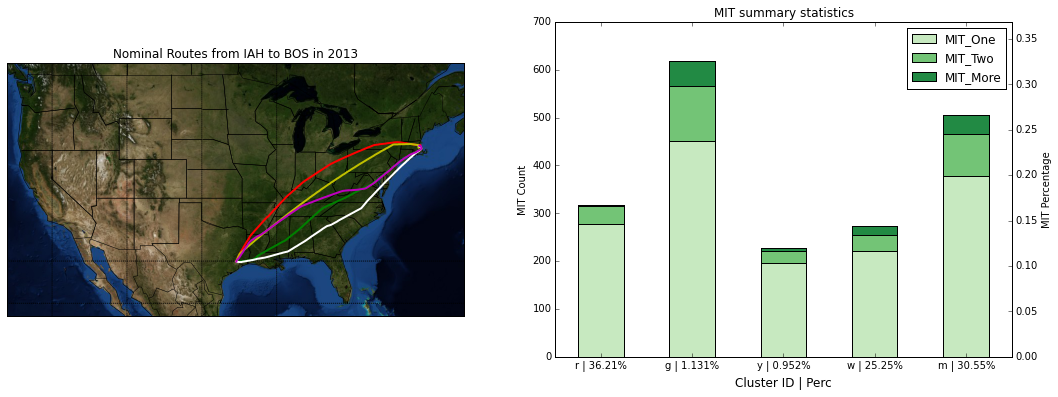

In [164]:
iah_bos = GetMIT_Map.MIT_MappingSummary('IAH','BOS',2013, True)

============1742 trajectories in total============
============5 nominal trajectories in total============


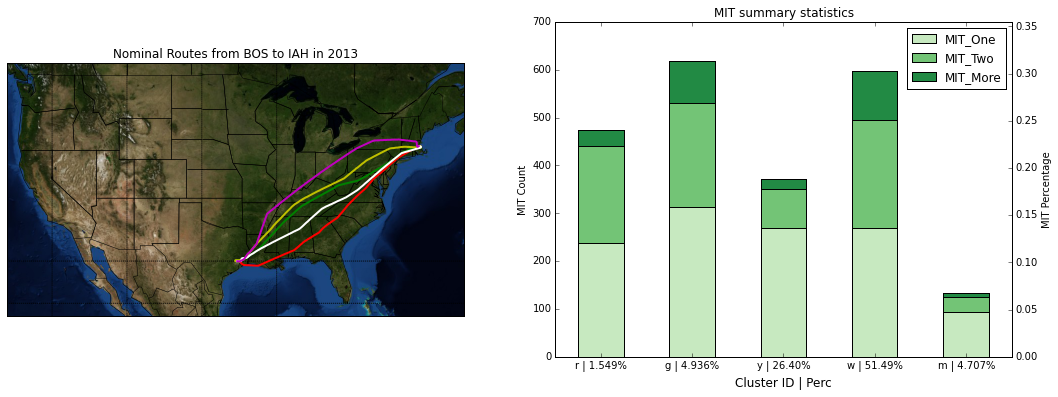

In [165]:
bos_iah = GetMIT_Map.MIT_MappingSummary('BOS','IAH',2013, True)

============4011 trajectories in total============
============3 nominal trajectories in total============


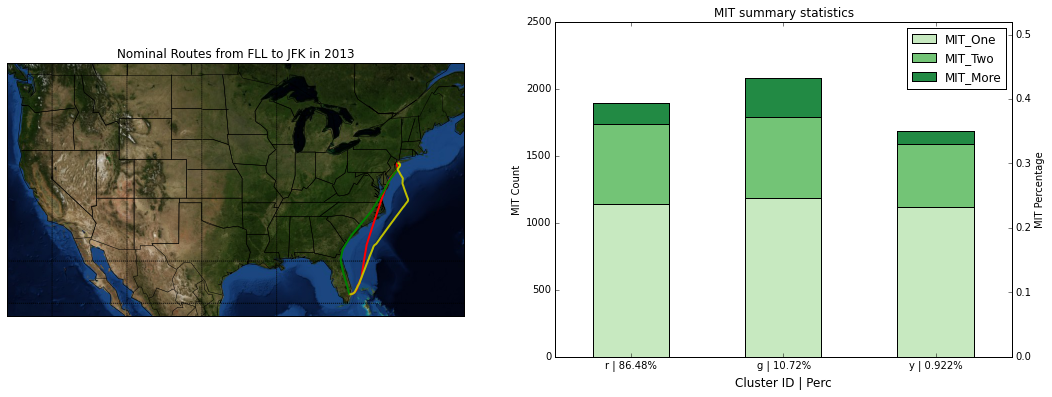

In [166]:
fll_jfk = GetMIT_Map.MIT_MappingSummary('FLL','JFK',2013, True)

============4043 trajectories in total============
============5 nominal trajectories in total============


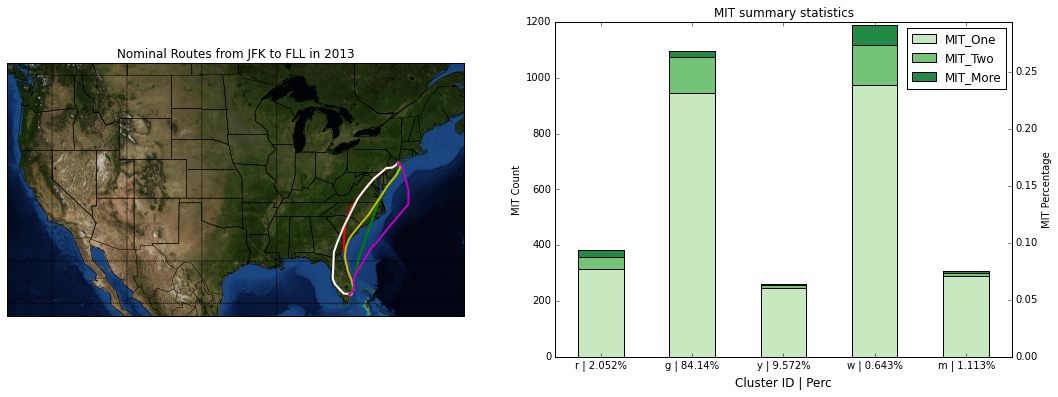

In [167]:
jfk_fll = GetMIT_Map.MIT_MappingSummary('JFK','FLL',2013, True)

============10440 trajectories in total============
============4 nominal trajectories in total============


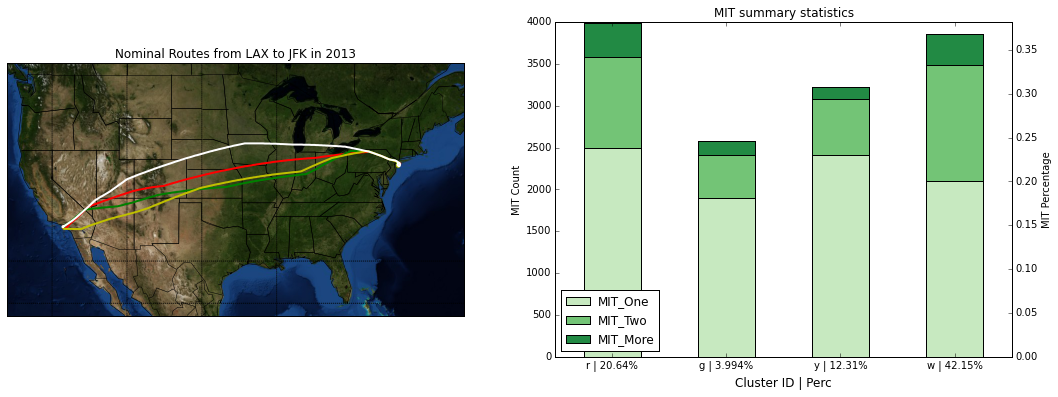

In [168]:
lax_jfk = GetMIT_Map.MIT_MappingSummary('LAX','JFK',2013, True)

============10712 trajectories in total============
============5 nominal trajectories in total============


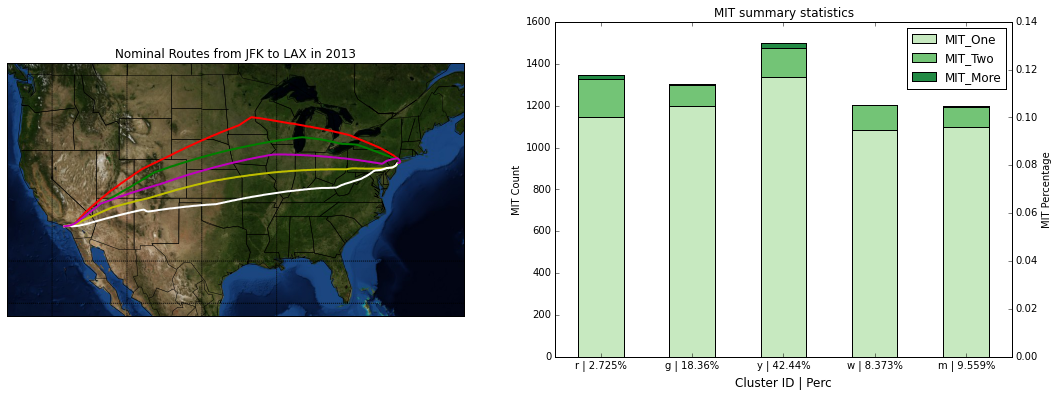

In [169]:
jfk_lax = GetMIT_Map.MIT_MappingSummary('JFK','LAX',2013, True)

============6063 trajectories in total============
============4 nominal trajectories in total============


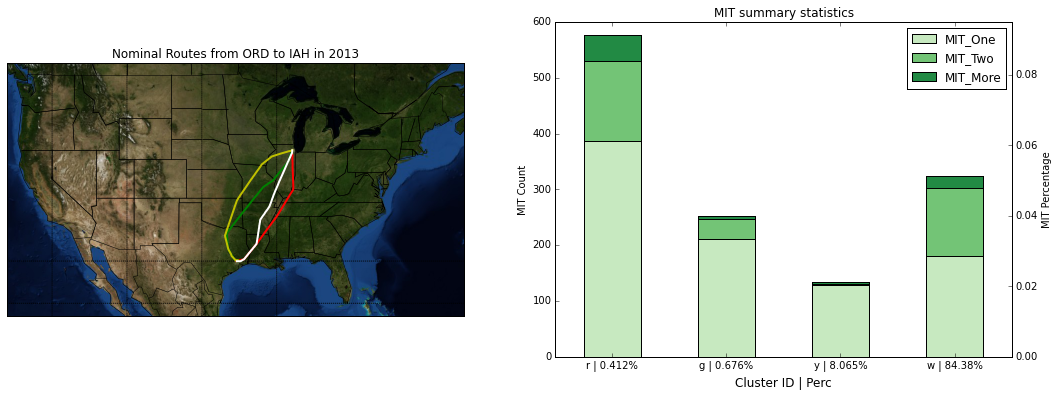

In [170]:
ord_iah = GetMIT_Map.MIT_MappingSummary('ORD','IAH',2013, True)

#### Merge based on Pickle file

In [118]:
def Count_Max_MIT(Map_MIT):
    max_mit = 0
    k = 0
    for FFID in Map_MIT.keys():
            for fid in Map_MIT[FFID].keys():
                count_mit = np.count_nonzero(Map_MIT[FFID][fid])
                if count_mit == 0:
                    k += 1
                if count_mit > max_mit:
                    max_mit = count_mit
                else:
                    pass
    return max_mit, k/(len(Map_MIT.keys())*len(Map_MIT[FFID].keys()))

def ConvertToDataFrame(Map_MIT, MIT_Enroute_VALUE):
    MIT_df = pd.DataFrame({(i,j): Map_MIT[i][j]
                            for i in Map_MIT.keys()
                                for j in Map_MIT[i].keys()}).T
    MIT_df = MIT_df.reset_index()
    MIT_df.columns = ['FFID','FID_Cluster', 'MIT_HEAD_ID']
    MIT_df = MIT_df.merge(MIT_Enroute_VALUE,left_on='MIT_HEAD_ID', right_on='HEADID',how = 'left')
    MIT_df = MIT_df.fillna(0)
    MIT_df['MIT_Count'] = MIT_df.MIT_HEAD_ID.apply(lambda x: int(x>0))
    MIT_df = MIT_df.drop(['HEADID'], axis = 1)
    MIT_df = MIT_df.sort_values(by=['FFID','FID_Cluster'])
    return MIT_df
def MergeWithMNL(MIT_MAP_DF, Dep, Arr, Year):
    MNL_data_withWind = pd.read_csv(os.getcwd() + '/MNL/NEW_MNL_' + Dep + Arr + str(Year) +'.csv')
    MNL_data_withWind = MNL_data_withWind.merge(MIT_MAP_DF, left_on=['FID_Member','FID_x'], right_on = ['FFID','FID_Cluster'],how='left')
    MNL_data_withWind[['MIT_HEAD_ID','MITVAL','DURATION_HRS_TOT','MIT_Count']] = \
        MNL_data_withWind[['MIT_HEAD_ID','MITVAL','DURATION_HRS_TOT','MIT_Count']].fillna(0)
    return MNL_data_withWind

In [163]:
for mapfile in os.listdir(os.getcwd() + '/TMI/MapResult'):
    print '-------',mapfile[:7],'-------'
    exec """Map_%s = pickle.load(open(os.getcwd() + '/TMI/MapResult/' + mapfile,'r'))""" % mapfile[:7]
    exec """print Count_Max_MIT(Map_%s)""" % mapfile[:7]
    exec """df_Map_%s = ConvertToDataFrame(Map_%s, MIT_Enroute_VALUE)""" % (mapfile[:7],mapfile[:7])
    exec """final_MNL = MergeWithMNL(df_Map_%s, mapfile[:3], mapfile[4:7], 2013)""" % mapfile[:7]
    exec """final_MNL.to_csv(os.getcwd() + '/MNL/Final_MNL_' + mapfile[:3] + mapfile[4:7] +'_2013.csv', index=False)"""

------- BOS_IAH -------
------- DCA_ORD -------
------- FLL_JFK -------
------- IAH_BOS -------
------- JFK_FLL -------
------- JFK_LAX -------
------- LAX_JFK -------
------- ORD_DCA -------


In [85]:
MNL_Data = pd.read_csv(os.getcwd()+'/MNL/NEW_MNL_IAHBOS2013.csv')

In [98]:
MNL_Data = MNL_Data.merge(df_Map_IAH_BOS, left_on=['FID_Member','FID_x'], right_on = ['FFID','FID_Cluster'],how='left')

In [116]:
MNL_Data[['MIT_HEAD_ID','MITVAL','DURATION_HRS_TOT','MIT_Count']] = \
MNL_Data[['MIT_HEAD_ID','MITVAL','DURATION_HRS_TOT','MIT_Count']].fillna(0)

In [117]:
MNL_Data.head(1)

,FID_x,FID_Member,TS_sum,TS_mean,TSlevel_sum,TSlevel_mean,Hail_sum,Hail_mean,Precipitation_sum,Precipitation_mean,...,Summer,Fall,Wind_Dist,MeanWindSpeed,FFID,FID_Cluster,MIT_HEAD_ID,MITVAL,DURATION_HRS_TOT,MIT_Count
0,99999999,20130101632288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0


In [72]:
a = pd.DataFrame({(i,j): Map_IAH_BOS[i][j]
                            for i in Map_IAH_BOS.keys()
                                for j in Map_IAH_BOS[i].keys()}).T

In [73]:
a = a.reset_index()
a.columns = ['FFID','FID_Cluster', 'MIT_HEAD_ID']

In [74]:
a = a.merge(MIT_Enroute_VALUE,left_on='MIT_HEAD_ID', right_on='HEADID',how = 'left')
a = a.fillna(0)
a['MIT_Count'] = a.MIT_HEAD_ID.apply(lambda x: int(x>0))
a = a.drop(['HEADID'], axis = 1)

In [336]:
for row in MIT_Enroute_geo.itertuples():
    if row.TOFACSINGLE == 'ZHU':
        b = row
    row

In [352]:
Traj_Line = []
Traj_Tree = {}
for fid in CenterTraj.FID.unique():
    traj_coords = np.array(zip(CenterTraj[CenterTraj.FID == fid].Lon, CenterTraj[CenterTraj.FID == fid].Lat))
    Traj_Line.append(LineString(traj_coords))
    Traj_Tree[fid] = [KDTree(traj_coords), CenterTraj[CenterTraj.FID == fid].DT.cumsum().values,\
                             CenterTraj[CenterTraj.FID == fid].Alt.values]

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import csv
import os
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from shapely.geometry import Point, LineString
import time
from dateutil.parser import parse
import GetCluster
import GetEDA
import geopandas as gpd
%matplotlib inline

#Clean Enroute MIT in 2013

In [152]:
from Get_Fix_Coords import FixCoords_NFDC

In [154]:
i = 0
ARTCC = ['ZAB', 'ZAU', 'ZNY', 'ZBW', 'ZDC', 'ZDV', 'ZFW', 
         'ZLA', 'ZHU', 'ZID', 'ZJX', 'ZKC', 'ZLC', 'ZMA', 
         'ZME', 'ZMP', 'ZOA', 'ZOB', 'ZSE', 'ZTL']
ARTCC.extend(['ALL','ALLFIXES','ALLROUTES'])
FixList = ['BENNR','DAYYY','DBABE','DEEZZ','HALEN','IGGGY',
           'IVANE','JIIMS','KILMR','MYRRS','NEWEL','PLDGE',
           'WEEDU','ZIMMZ','ZZIPR']
# Notice the mistake of JJ518

with open(os.getcwd() + '/TMI/MIT_Enroute_2013.csv', 'wb') as wcsvfile:
    wline = csv.writer(wcsvfile)
    with open(os.getcwd() + '/TMI/raw/TMI2013_2014.csv','r') as csvfile:
        line = csv.reader(csvfile)
        for row in line:
            i += 1
            if i == 1:
                wline.writerow(row)
            else:
                if 'MIT' in row[8] and '-13' in row[17] and 'Enroute' in row[20]:
                    row[17] = str(parse(row[17]))
                    row[18] = str(parse(row[18]))
                    if row[31] == '':
                        if row[30] in ARTCC:
                            row[31] = 'POLY'
                        elif row[30] in ['BWI','MMU','DFW','ASE','AFW','AMA','BCT']:
                            row[31] = 'NAVAID'
                        elif row[30] in FixList:
                            row[31] = 'FIX'
                    wline.writerow(row)
                else:
                    pass

In [169]:
Coords = {}
for fixes in FixList:
    Coords[fixes] = FixCoords_NFDC(fixes)

#Clean US Navaids

In [101]:
i = 0
with open(os.getcwd() + '/TMI/US_Fixes.csv', 'wb') as wcsvfile:
    wline = csv.writer(wcsvfile)
    with open(os.getcwd() + '/TMI/raw/Fixes.csv','r') as csvfile:
        line = csv.reader(csvfile)
        for row in line:
            i += 1
            if i == 1:
                wline.writerow([row[0],row[1],row[3],row[4],row[7],row[9],row[11]])
            else:
                if row[5] == 'US':
                    wline.writerow([row[0],row[1],row[3],row[4],row[7],row[9],row[11]])
                else:
                    pass

# Load Fixes

In [17]:
Fixes = pd.read_csv(os.getcwd() + '/TMI/US_Fixes_Mo.csv')

In [18]:
Fixes[Fixes.DATA_SOURCE.isin(['NFDC','CIFP'])].groupby('NAME').count().reset_index(drop = 0).sort_values(by = 'LAT',ascending = False)

,NAME,COMBO_NAME,DATA_SOURCE,TYPE,LAT,LON,VARIATION
44364,ORW,2,2,2,2,2,2
17472,DNBBD,2,2,2,2,2,1
45672,PERSN,2,2,2,2,2,2
41041,MPV,2,2,2,2,2,2
24781,GRENE,2,2,2,2,2,2
40726,MODDA,1,1,1,1,1,1
40730,MODEM,1,1,1,1,1,1
40729,MODEL,1,1,1,1,1,1
40728,MODEE,1,1,1,1,1,1
40727,MODDS,1,1,1,1,1,1


In [19]:
# Drop DAFIF
Fixes_Main = Fixes[Fixes.DATA_SOURCE.isin(['NFDC','CIFP'])].reset_index(drop = 1)

# Load MIT Data

In [18]:
MIT = pd.read_csv(os.getcwd()+'/TMI/MIT_Enroute_2013.csv', sep = ',', 
                  usecols = [0,1,3,7,8,13,14,15,17,18,23,25,26,27,28,29,30,31],parse_dates=[8,9])

IOError: File G:\GoogleDrive\Berkeley_Research\03_Efficiency\05_TFMS_Traj/TMI/MIT_Enroute_2013.csv does not exist

In [3]:
MIT.head()

,HEADID,ENTRYID,TYPE,RSTNID,RSTN_TYPE_TEXT,FRFAC,TOFAC,TOFACSINGLE,RSTN_START,RSTN_STOP,ALT,SPD,MITVAL,DURATION_HRS_TOT,DURATION_HRS_ADD,STRINGENCY_MIT_HRS,NAS_ELEM_SINGLE,NAS_ELEM_TYPE
0,5060344,188549841,4,5060344,MIT,ZTL,ZME,ZME,2013-01-01 01:00:00,2013-01-01 01:45:00,,NaN,15,0.75,0.75,11.25,ATL,NAVAID
1,5060344,188549841,4,5060344,MIT,ZTL,ZME,ZME,2013-01-01 01:00:00,2013-01-01 01:45:00,,NaN,15,0.75,0.75,11.25,VXV,NAVAID
2,5060356,188550703,4,5060356,MIT,ZLA,ZOA,ZOA,2013-01-01 00:00:00,2013-01-01 00:45:00,,NaN,10,0.75,0.75,7.50,BTY,NAVAID
3,5060358,188550872,4,5060358,MIT,ZLA,ZOA,ZOA,2013-01-01 00:15:00,2013-01-01 01:15:00,,NaN,15,1.00,1.00,15.00,EHF,NAVAID
4,5060359,188551008,4,5060359,MIT,ZLA,ZLC,ZLC,2013-01-01 00:15:00,2013-01-01 01:15:00,,NaN,15,1.00,1.00,15.00,CORKR,FIX


In [54]:
ARTCC = ['ZAB', 'ZAU', 'ZNY', 'ZBW', 'ZDC', 'ZDV', 'ZFW', 
         'ZLA', 'ZHU', 'ZID', 'ZJX', 'ZKC', 'ZLC', 'ZMA', 
         'ZME', 'ZMP', 'ZOA', 'ZOB', 'ZSE', 'ZTL']

In [55]:
print MIT.shape
print MIT.HEADID.unique().shape
print MIT.NAS_ELEM_SINGLE.unique().shape
print MIT[MIT.FRFAC.isin(ARTCC)].shape

(103412, 18)
(67572L,)
(1067L,)
(100873, 18)


In [56]:
MIT_Filter = MIT[(pd.isnull(MIT.NAS_ELEM_TYPE)==0) & (MIT.DURATION_HRS_TOT > 0) & (MIT.MITVAL > 0)&
                 (MIT.FRFAC.isin(ARTCC))&(MIT.TOFACSINGLE.isin(ARTCC))]

In [5]:
# Drop Non NAS ELEM TYPE
# Drop Total Time <= 0
# Drop MITVAL <= 0
MIT_Filter = MIT[(pd.isnull(MIT.NAS_ELEM_TYPE)==0) & (MIT.DURATION_HRS_TOT > 0) & (MIT.MITVAL > 0)].reset_index(drop = 1)

In [58]:
MIT_Filter.head(1)

,HEADID,ENTRYID,TYPE,RSTNID,RSTN_TYPE_TEXT,FRFAC,TOFAC,TOFACSINGLE,RSTN_START,RSTN_STOP,ALT,SPD,MITVAL,DURATION_HRS_TOT,DURATION_HRS_ADD,STRINGENCY_MIT_HRS,NAS_ELEM_SINGLE,NAS_ELEM_TYPE
0,5060344,188549841,4,5060344,MIT,ZTL,ZME,ZME,2013-01-01 01:00:00,2013-01-01 01:45:00,,NaN,15,0.75,0.75,11.25,ATL,NAVAID


In [57]:
print MIT_Filter.shape
print MIT_Filter.HEADID.unique().shape
print MIT_Filter.NAS_ELEM_SINGLE.unique().shape
print MIT_Filter.NAS_ELEM_TYPE.unique()

(82585, 18)
(56267L,)
(631L,)
['NAVAID' 'FIX' 'AIRWAY' 'POLY']


In [59]:
MIT_Merge = MIT_Filter.merge(Fixes_Main[['NAME','LAT','LON']], left_on = 'NAS_ELEM_SINGLE', right_on = 'NAME', how = 'inner')
print(MIT_Merge.shape)

(64186, 21)


In [60]:
MIT_Merge.head(1)

,HEADID,ENTRYID,TYPE,RSTNID,RSTN_TYPE_TEXT,FRFAC,TOFAC,TOFACSINGLE,RSTN_START,RSTN_STOP,...,SPD,MITVAL,DURATION_HRS_TOT,DURATION_HRS_ADD,STRINGENCY_MIT_HRS,NAS_ELEM_SINGLE,NAS_ELEM_TYPE,NAME,LAT,LON
0,5060344,188549841,4,5060344,MIT,ZTL,ZME,ZME,2013-01-01 01:00:00,2013-01-01 01:45:00,...,NaN,15,0.75,0.75,11.25,ATL,NAVAID,ATL,33.629083,-84.435083


#Visualize MIT

In [4]:
ARTCC = gpd.GeoDataFrame.from_file(os.getcwd()+'/ARTCC/artcc_cont.shp')

In [5]:
ARTCC.head(1)

,AltMode,Base,Clamped,Extruded,FolderPath,Name,OID_,PopupInfo,Shape_Area,Shape_Leng,Snippet,SymbolID,geometry
0,0,0.0,-1,0,Document/ARTCC,ARTCC ZAB,0,None,59.630341,41.590749,None,0,POLYGON Z ((-111.841666667 35.76666666700004 0...


In [7]:
import GetEDA

In [8]:
st = time.time()
bwi_sfo = GetEDA.EDA_Data('BWI','SFO',2013,Cutoff=0.5, InputData=True)
print time.time() - st


Inefficiency File Loaded
Valid Track File Loaded
0.638000011444


In [9]:
FTrack = bwi_sfo.VTrack.copy()

In [10]:
def PlotMIT(fromTC, toTC, Element, MAP):
    ReqTC = np.array(ARTCC[ARTCC.Name == fromTC]['geometry'].get_values()[0].exterior.coords)
    ProTC = np.array(ARTCC[ARTCC.Name == toTC]['geometry'].get_values()[0].exterior.coords)
    NAS_elem = np.array(Point(Fixes_Main[Fixes_Main.NAME == Element][['LON','LAT']].get_values()[0]).buffer(0.15).exterior.coords)
    ReqTC_X, ReqTC_Y = MAP(ReqTC[:,0],ReqTC[:,1])
    ProTC_X, ProTC_Y = MAP(ProTC[:,0],ProTC[:,1])
    ELE_X, ELE_Y = MAP(NAS_elem[:,0], NAS_elem[:,1])
    ReqPoly = Polygon(zip(ReqTC_X, ReqTC_Y), facecolor = 'y', alpha = 0.6, zorder = 10, label = 'From: ' + fromTC)
    ProPoly = Polygon(zip(ProTC_X, ProTC_Y), facecolor = 'g', alpha = 0.6, zorder = 10, label = 'To: ' + toTC)
    ELEPoly = Polygon(zip(ELE_X, ELE_Y), facecolor = 'r', alpha = 0.9, zorder = 15, label = 'NAS Element: ' + Element)
    plt.gca().add_patch(ReqPoly)
    plt.gca().add_patch(ProPoly)
    plt.gca().add_patch(ELEPoly)

In [17]:
MIT_Merge[(MIT_Merge.FRFAC=='ZDC')&(MIT_Merge.TOFAC == 'ZNY')&(MIT_Merge.NAS_ELEM_SINGLE == 'WHITE')]

NameError: name 'MIT_Merge' is not defined

In [15]:
from mpl_toolkits.basemap import Basemap

NameError: name 'MIT_Merge' is not defined

E:\Anaconda\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


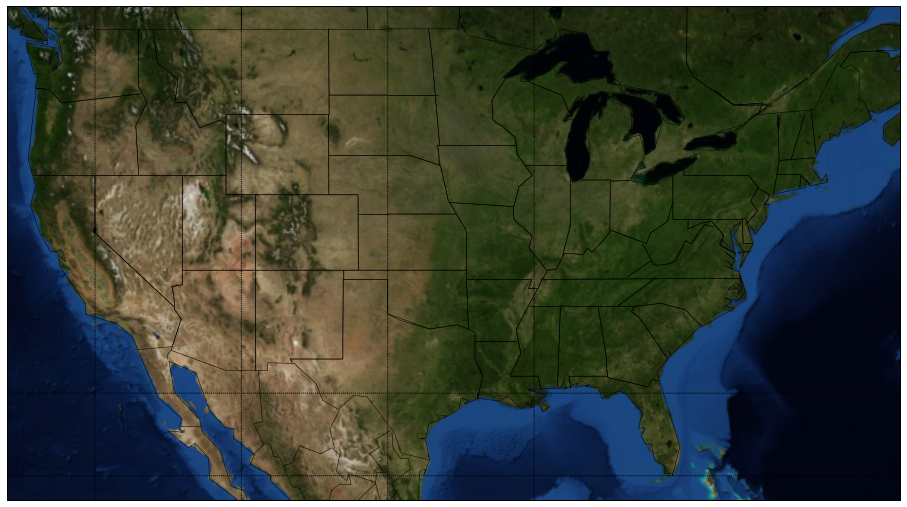

In [16]:
fromTC = 'ARTCC ZHU'
toTC = 'ARTCC ZTL'
Element = 'SJI'

xlb = -126
xrb = -65
ylb = 23.5
yub = 50

fig = plt.figure(figsize=(16,12))
m = Basemap(llcrnrlon = xlb,llcrnrlat = ylb,urcrnrlon = xrb,urcrnrlat = yub,projection='merc')
m.bluemarble()
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=0.5)
m.drawstates(linewidth=0.5)
m.drawparallels(np.arange(10.,35.,5.))
m.drawmeridians(np.arange(-120.,-80.,10.))

i = 0
PlotMIT('ARTCC ' + MIT_Merge.loc[i, 'FRFAC'], 'ARTCC ' + MIT_Merge.loc[i, 'TOFAC'], MIT_Merge.loc[i, 'NAS_ELEM_SINGLE'], m)
# PlotMIT('ARTCC ' + MIT_Merge.loc[i, 'FRFAC'], 'ARTCC ' + MIT_Merge.loc[i, 'TOFAC'], 'GVE', m)

# tz_coords = FTrack[FTrack.FID == FTrack.FID.unique()[0]][['Lon','Lat']].get_values()
# tz_x, tz_y = m(tz_coords[:,0],tz_coords[:,1])
# plt.plot(tz_x, tz_y, '-', zorder = 20, lw = 1, color = 'w', label = 'Flight Track')

LEGEND = plt.legend(loc = 0, fontsize = 18)
LEGEND.get_frame().set_facecolor('#C0C0C0')

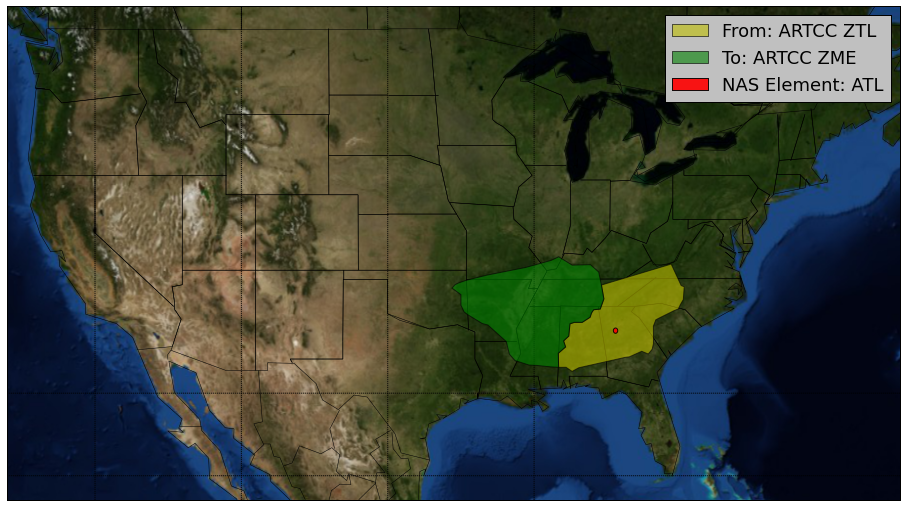

In [80]:
fromTC = 'ARTCC ZHU'
toTC = 'ARTCC ZTL'
Element = 'SJI'

xlb = -126
xrb = -65
ylb = 23.5
yub = 50

fig = plt.figure(figsize=(16,12))
m = Basemap(llcrnrlon = xlb,llcrnrlat = ylb,urcrnrlon = xrb,urcrnrlat = yub,projection='merc')
m.bluemarble()
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=0.5)
m.drawstates(linewidth=0.5)
m.drawparallels(np.arange(10.,35.,5.))
m.drawmeridians(np.arange(-120.,-80.,10.))

i = 0
PlotMIT('ARTCC ' + MIT_Merge.loc[i, 'FRFAC'], 'ARTCC ' + MIT_Merge.loc[i, 'TOFAC'], MIT_Merge.loc[i, 'NAS_ELEM_SINGLE'], m)
# PlotMIT('ARTCC ' + MIT_Merge.loc[i, 'FRFAC'], 'ARTCC ' + MIT_Merge.loc[i, 'TOFAC'], 'GVE', m)

# tz_coords = FTrack[FTrack.FID == FTrack.FID.unique()[0]][['Lon','Lat']].get_values()
# tz_x, tz_y = m(tz_coords[:,0],tz_coords[:,1])
# plt.plot(tz_x, tz_y, '-', zorder = 20, lw = 1, color = 'w', label = 'Flight Track')

LEGEND = plt.legend(loc = 0, fontsize = 18)
LEGEND.get_frame().set_facecolor('#C0C0C0')